In [10]:
# Import required libraries

import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "Arial"
import pandas as pd
from pandas import Timedelta
import numpy as np
%matplotlib inline
import databaseQuery
from math import isnan

In [11]:

startDateTime = pd.to_datetime('2015-11-27 00:00:00')
stopDateTime = pd.to_datetime('2020-12-01 00:00:00')

# Import pressure data
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
# 2959	Rainfall mm TB4 WSSR   (1785 at angelo meadow)
#2964	Wind Speed ms Avg WSSR (49 at angelo meadow)
sagehornPrecip = databaseQuery.odmquery(dateStart, dateStop, '2959', True)
# sagehornPrecip = databaseQuery.odmquery(dateStart, dateStop, '1785', True)

sagehornWind = databaseQuery.odmquery(dateStart, dateStop, '2964', True)
# sagehornWind = databaseQuery.odmquery(dateStart, dateStop, '49', True)



In [12]:
sagehornPrecip.columns=['sagehornPrecip'] #mm
sagehornWind.columns=['sagehornWind']     #m/s


merged = sagehornPrecip.merge(sagehornWind,left_index=True, right_index=True,how='inner')

merged.head()

,sagehornPrecip,sagehornWind
LocalDateTime,,
2015-11-27 00:00:00,0.0,1.852
2015-11-27 00:05:00,0.0,1.660
2015-11-27 00:10:00,0.0,1.728
2015-11-27 00:15:00,0.0,1.646
2015-11-27 00:20:00,0.0,1.276


In [13]:
#correct wind speed to height of rain gauge, assuming 0.1 m roughness layer
#Yang et al 1998 Accuracy of NWS 8" standard nonrecording precipitation gauge: Results and application of WMO intercomparison, J. Atmos. Oceanic Technol. , 15 , 54–68.
merged['sagehornWindSpeed_HeightAdjusted'] = (np.log(1.5/0.1)/np.log(3/0.1))*merged['sagehornWind']


In [14]:
#Yang et al 1998 Accuracy of NWS 8" standard nonrecording precipitation gauge: Results and application of WMO intercomparison, J. Atmos. Oceanic Technol. , 15 , 54–68.
merged['CFyang']=0.01*np.exp(4.605-0.062*merged['sagehornWindSpeed_HeightAdjusted']**0.58)

In [15]:
merged['CFyang'].describe()

count    151832.000000
mean          0.931215
std           0.034588
min           0.773459
25%           0.910217
50%           0.936897
75%           0.955586
max           0.999830
Name: CFyang, dtype: float64

In [16]:
merged['sagehornPrecipUndercatchCorrected-mm']=merged['sagehornPrecip']/merged['CFyang']

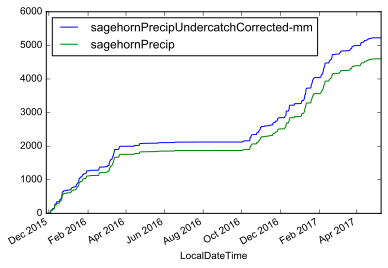

In [17]:
merged['sagehornPrecipUndercatchCorrected-mm'].cumsum().plot()
merged['sagehornPrecip'].cumsum().plot()
plt.legend(loc='best')

In [18]:
100*(1-merged['sagehornPrecip'].sum()/merged['sagehornPrecipUndercatchCorrected-mm'].sum())
#percent diff

11.983843934137806

In [19]:
# 5.13 percent for angelo meadow for 2016 and 2017 water years